# AD, QLattice, Ubuntu, 25-11-21

In [1]:
from platform import python_version
print(python_version())

3.8.10


In [51]:
import numpy as np
import pandas as pd
import feyn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from functions import modsum, model_features_chart, crossvalidation_as_framework

feyn._qlattice._USE_V2_API=True

In [3]:
feyn.__version__

'2.1.1'

In [4]:
# Load the data
data = pd.read_csv("../data/ad_omics.csv")

In [5]:
# Define the semantic types
stypes = {}
for f in data.columns:
    if data[f].dtype =='object':
        stypes[f] = 'c'
        
# Set random seed for reproducibility
random_seed = 42

In [6]:
target = "_clinical AD diagnosis"

## In depth modelling

In [25]:
projectname = 'ad_ms_proteomics_'
pathname = '../figures'

### Get the test data

In [40]:
random_seed = 42
train_val, test = train_test_split(data, test_size=0.2, stratify=data[target], random_state=random_seed)

In [41]:
epochs = 50
criterion = 'bic'
max_complexity = 5
random_seed = 42
sw = np.where(train_val[target] == 1, np.sum(train_val[target] == 0)/sum(train_val[target]), 1)

In [42]:
ql = feyn.connect_qlattice(server="https://qlattice.stage.abzu.ai") # Connecting
ql.reset(random_seed) # Resetting
models_single = ql.auto_run(data = train_val,
                         output_name = target,
                         kind = "classification",
                         stypes = stypes,
                         n_epochs = epochs,
                         criterion=criterion,
                         max_complexity = max_complexity,
                         sample_weights=sw)

## Model summary

In [43]:
modsum(models_single, train_val, test)

,Model,AUC Train,AUC Test,BIC,NumFeatures,Loss
0,0,0.98,0.93,48.33,3,0.178640
1,1,0.97,0.92,52.8,3,0.199162
2,2,0.97,0.99,55.22,3,0.210283
3,3,0.96,0.94,56.2,3,0.214738
4,4,0.97,0.94,58.57,3,0.225644
5,5,0.96,0.94,60.29,3,0.233542
6,6,0.97,0.94,60.8,3,0.214344
7,7,0.96,0.91,62.41,3,0.243263
8,8,0.96,0.93,64.77,2,0.275580
9,9,0.96,0.94,65.36,2,0.278287


## Best model from autorun (BIC criterion)

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 741 232.0" width="741" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="471" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="50.0"><title>_clinical AD diagnosis
logistic:
w=4.6055
bias=0.2897</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">_clinica..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="59.0">out</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">1</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">2</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>IGHV3-38
linear:
scale=0.000003
scale offset=191686.857081
w=-1.076860
bias=-0.0808</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">IGHV3-38</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>LILRA2
linear:
scale=0.000067
scale offset=12680.903070
w=-1.097455
bias=0.0707</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">LILRA2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>MAPT
linear:
scale=0.000038
scale offset=24135.487526
w=2.687544
bias=-0.3566</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">MAPT</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="89.0">num</text></svg><svg class="summary" height="79" width="180" x="471" y="0"><defs /><text fill="#1E1E1E" fo
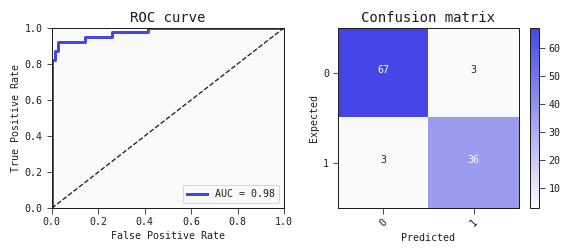
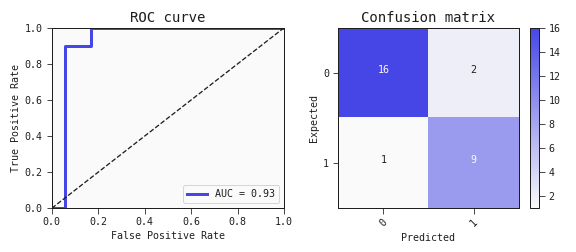

In [44]:
models_single[0].plot(train_val,test)

# Plot feature conservation across models with dirac

In [45]:
model_features_chart(train_val, models_single, metric="roc_auc_score")

,agreement,roc_auc_score,MAPT,IGHV3-38,LILRA2,AP2B1,CRP,PROS1,ZP2,AJAP1,EFNA5,LDHA,ENDOD1,CD163,SERPINE2.1,LTA4H,ATP6AP2,NXPH3
Model#,,,,,,,,,,,,,,,,,,
0,1.000000,0.976923,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0.944954,0.973260,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0.926606,0.972894,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
4,0.917431,0.972161,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False
6,0.917431,0.965201,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
3,0.917431,0.963736,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7,0.908257,0.961905,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
5,0.917431,0.960440,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
9,0.853211,0.958242,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [21]:
#excello = model_features_chart(test, models_single, metric="roc_auc_score")

In [22]:
#excello.to_excel('AD_QLAttice_Ubuntu_features_chart_autorun_best_251121.xlsx')

# Exploring model 0 further

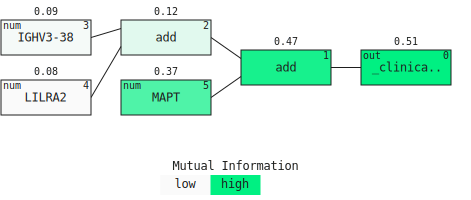

In [47]:
models_single[0].plot_signal(train_val,corr_func='mutual_information',filename=pathname+projectname+'bestmodel_signal_MI'+'.svg')

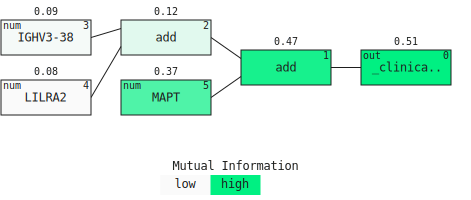

In [48]:
models_single[0].plot_signal(train_val,corr_func='mutual_information')

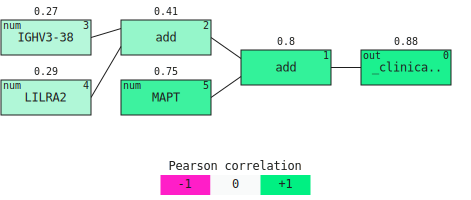

In [50]:
models_single[0].plot_signal(train_val, corr_func='pearson',filename=pathname+projectname+'bestmodel_signal_PEARSON'+'.svg')

In [29]:
sympy_model = models_single[0].sympify(symbolic_lr = True, signif=3)
sympy_model.as_expr()

1/(189.0*exp(1.74e-5*IGHV3-38 + 0.000339*LILRA2 - 0.000475*MAPT) + 1)

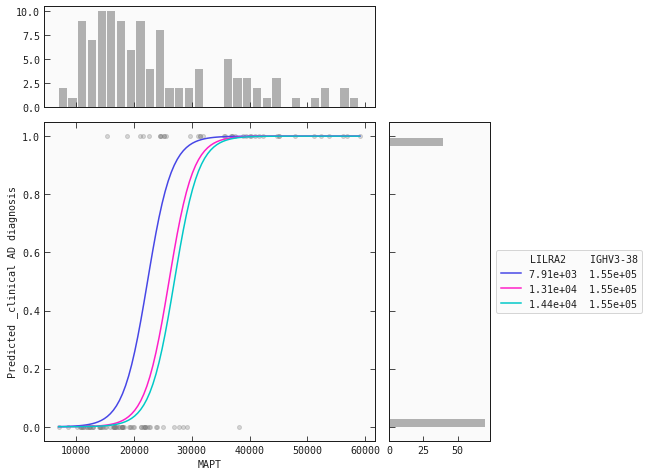

In [30]:
show_quantiles = 'LILRA2'
fixed = {}
fixed[show_quantiles] = [
    train_val[show_quantiles].quantile(q=0.25),
    train_val[show_quantiles].quantile(q=0.5),
    train_val[show_quantiles].quantile(q=0.75)
]

models_single[0].plot_response_1d(train_val, by = "MAPT", input_constraints=fixed)

# Cross-validation as a framework

In [52]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = epochs,
                                     criterion=criterion,
                                     max_complexity = max_complexity)

In [53]:
# average performance of first 10 models
results.roc_auc.mean(), results.accuracy.mean()

AttributeError: 'DataFrame' object has no attribute 'roc_auc'

In [ ]:
# average performance of first model
results.groupby("model_structure").first().roc_auc.mean(), results.groupby("model_structure").first().accuracy.mean()

# Exploring model 5 further

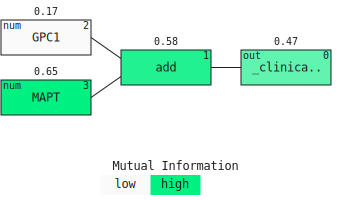

In [29]:
models_single[5].plot_signal(test,corr_func='mutual_information',filename=pathname+projectname+'bestmodelCV_signal_MI'+'.svg')

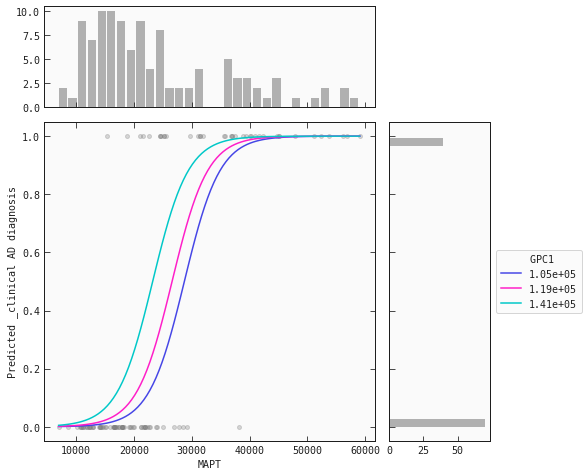

In [30]:
show_quantiles = 'GPC1'
fixed = {}
fixed[show_quantiles] = [
    train_val[show_quantiles].quantile(q=0.25),
    train_val[show_quantiles].quantile(q=0.5),
    train_val[show_quantiles].quantile(q=0.75)
]

models_single[5].plot_response_1d(train_val, by = "MAPT", input_constraints=fixed)